# 24차시: [실습] LSTM 모델을 활용한 주가 예측

## 학습 목표
- 실제 주가 데이터로 LSTM 모델 구축
- 시계열 데이터 전처리 및 스케일링
- 모델 학습, 평가, 예측 수행

## 학습 내용
1. 주가 데이터 수집 (FinanceDataReader)
2. 데이터 전처리
3. LSTM 모델 구축
4. 학습 및 평가
5. 예측 결과 분석

## 중요 주의사항 (Warning)

본 교재와 실습에서 사용하는 모든 데이터, 모델, 기법은
오직 딥러닝·LSTM 개념 이해와 교육 목적을 위한 예제입니다. 따라서,
실제 금융 시장의 복잡성, 리스크, 거래 비용, 정책·심리 요인 등을 전혀 반영하지 못하며, 실제 투자 판단이나 매매 전략에 사용해서는 안 됩니다.

실습 결과는 "참고용·학습용"으로만 활용하시기 바랍니다.

In [1]:
!pip install -Uq finance-datareader koreanize-matplotlib

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import koreanize_matplotlib
from datetime import datetime, timedelta
from IPython.display import display

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler

---
## 1. 주가 데이터 수집

In [3]:
import FinanceDataReader as fdr

# 날짜 설정 (최근 2년)
end_date = datetime.now()
start_date = end_date - timedelta(days=730)

print("[데이터 수집]")
print("=" * 50)
print(f"기간: {start_date.strftime('%Y-%m-%d')} ~ {end_date.strftime('%Y-%m-%d')}")
print("종목: 삼성전자 (005930)")

# 삼성전자 주가 데이터
df = fdr.DataReader("005930", start_date, end_date)

df = df.reset_index()
df.columns = ['날짜', '시가', '고가', '저가', '종가', '거래량', '등락률']

print(f"\n수집된 데이터: {len(df)}개")
display(df.tail())

[데이터 수집]
기간: 2024-01-07 ~ 2026-01-06
종목: 삼성전자 (005930)

수집된 데이터: 485개


,날짜,시가,고가,저가,종가,거래량,등락률
480,2025-12-29,119400,119700,118200,119500,19676004,0.021368
481,2025-12-30,119100,121200,118700,119900,19746349,0.003347
482,2026-01-02,120200,128500,120200,128500,30463279,0.071726
483,2026-01-05,134600,138600,133600,138100,42863376,0.074708
484,2026-01-06,135300,139300,132700,138900,45208323,0.005793


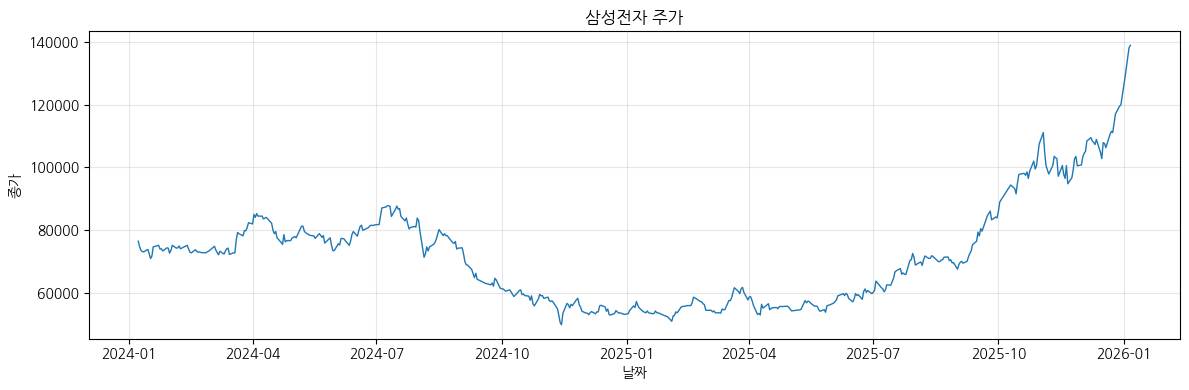

In [4]:
# 종가 시각화
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(df['날짜'], df['종가'], linewidth=1)
ax.set_xlabel('날짜')
ax.set_ylabel('종가')
ax.set_title('삼성전자 주가')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

---
## 2. 데이터 전처리

### LSTM 입력 형태
- `(samples, timesteps, features)`
- samples: 학습 샘플 수
- timesteps: 시퀀스 길이 (과거 몇 일?)
- features: 특성 수 (종가만 사용시 1)

In [5]:
# 종가 데이터 추출
close_prices = df['종가'].values.reshape(-1, 1)

print("[원본 데이터]")
print("=" * 50)
print(f"Shape: {close_prices.shape}")
print(f"최소값: {close_prices.min():,}원")
print(f"최대값: {close_prices.max():,}원")

[원본 데이터]
Shape: (485, 1)
최소값: 49,900원
최대값: 138,900원


In [6]:
# MinMaxScaler로 0~1 정규화
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(close_prices)

print("\n[정규화 후]")
print("=" * 50)
print(f"최소값: {scaled_data.min():.4f}")
print(f"최대값: {scaled_data.max():.4f}")


[정규화 후]
최소값: 0.0000
최대값: 1.0000


In [7]:
# 시퀀스 데이터 생성
def create_sequences(data, seq_length):
    """
    과거 seq_length 일의 데이터로 다음날 종가를 예측하는 시퀀스 생성
    """
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

# 시퀀스 길이 설정
SEQ_LENGTH = 60  # 과거 60일(약 3개월) 데이터 사용

X, y = create_sequences(scaled_data, SEQ_LENGTH)

print(f"[시퀀스 데이터]")
print("=" * 50)
print(f"X shape: {X.shape} (샘플, 시퀀스길이, 특성)")
print(f"y shape: {y.shape}")

[시퀀스 데이터]
X shape: (425, 60, 1) (샘플, 시퀀스길이, 특성)
y shape: (425, 1)


In [8]:
# 학습/테스트 분할 (시계열이므로 순서 유지)
train_size = int(len(X) * 0.8)

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f"\n[데이터 분할]")
print("=" * 50)
print(f"학습 데이터: {len(X_train)}개")
print(f"테스트 데이터: {len(X_test)}개")


[데이터 분할]
학습 데이터: 340개
테스트 데이터: 85개


---
## 3. LSTM 모델 구축

In [9]:
# LSTM 모델 정의
model = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=(SEQ_LENGTH, 1)),
    Dropout(0.2),
    LSTM(units=50, return_sequences=False),
    Dropout(0.2),
    Dense(units=25, activation='relu'),
    Dense(units=1)
])

# 컴파일
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

print("[LSTM 모델 구조]")
print("=" * 50)
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[LSTM 모델 구조]


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,901 (124.61 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)

### 모델 구조 설명
| 층 | 설명 |
|----|------|
| LSTM (50) | 첫 번째 LSTM, 50 유닛, 시퀀스 출력 |
| Dropout (0.2) | 과적합 방지 (20% 뉴런 비활성화) |
| LSTM (50) | 두 번째 LSTM, 50 유닛 |
| Dropout (0.2) | 과적합 방지 |
| Dense (25) | 완전연결층, ReLU 활성화 |
| Dense (1) | 출력층 (다음날 주가) |

---
## 4. 학습 및 평가

In [10]:
# Early Stopping 설정
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

print("[모델 학습 시작]")
print("=" * 50)

# 모델 학습
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stop],
    verbose=1
)

print(f"\n학습 완료! (Epochs: {len(history.history['loss'])})")

[모델 학습 시작]
Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 114ms/step - loss: 0.0169 - mae: 0.0984 - val_loss: 0.0010 - val_mae: 0.0285
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0048 - mae: 0.0569 - val_loss: 0.0029 - val_mae: 0.0507
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0023 - mae: 0.0359 - val_loss: 0.0014 - val_mae: 0.0311
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0014 - mae: 0.0280 - val_loss: 0.0014 - val_mae: 0.0303
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0016 - mae: 0.0297 - val_loss: 0.0021 - val_mae: 0.0399
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0019 - mae: 0.0319 - val_loss: 0.0020 - val_mae: 0.0398
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - loss: 0.0016 - mae: 0.0303 - val_loss: 7.6536e-04 - val_mae: 0.0213
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 0.0017 - mae: 0.0317 - val_loss: 0.0015 - val_mae: 0.0330
Epoch 9/100
10/10 ━━━━━━━━━━━━━━━━━━━━

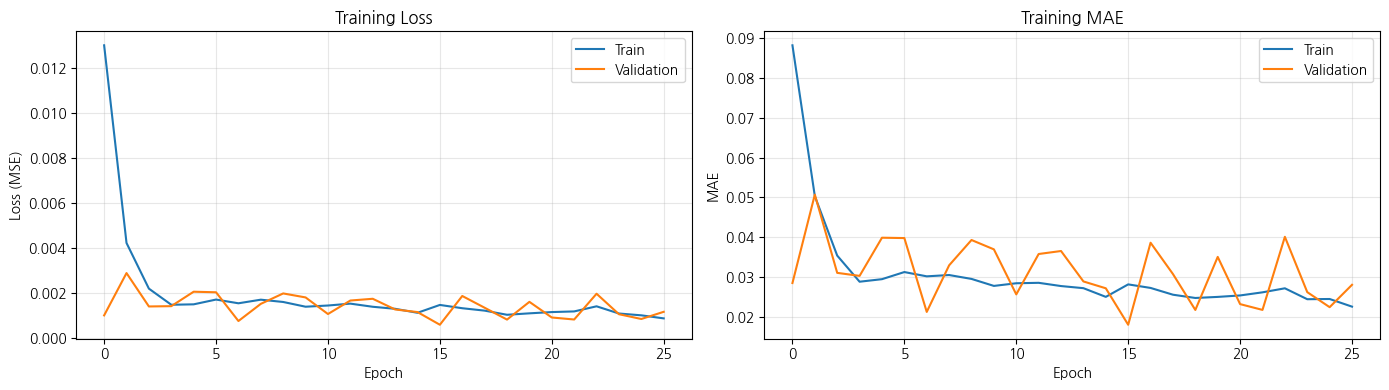

In [11]:
# 학습 곡선 시각화
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Loss
axes[0].plot(history.history['loss'], label='Train')
axes[0].plot(history.history['val_loss'], label='Validation')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss (MSE)')
axes[0].set_title('Training Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# MAE
axes[1].plot(history.history['mae'], label='Train')
axes[1].plot(history.history['val_mae'], label='Validation')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('MAE')
axes[1].set_title('Training MAE')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [12]:
# 테스트 데이터 예측
y_pred_scaled = model.predict(X_test)

# 역정규화 (원래 가격으로 변환)
y_pred = scaler.inverse_transform(y_pred_scaled)
y_actual = scaler.inverse_transform(y_test)

print("[예측 결과]")
print("=" * 50)

# 평가 지표
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(y_actual, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_actual, y_pred)

print(f"MSE:  {mse:,.0f}")
print(f"RMSE: {rmse:,.0f}원 (평균 오차)")
print(f"MAE:  {mae:,.0f}원")

# MAPE (Mean Absolute Percentage Error)
mape = np.mean(np.abs((y_actual - y_pred) / y_actual)) * 100
print(f"MAPE: {mape:.2f}%")

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 169ms/step
[예측 결과]
MSE:  33,804,680
RMSE: 5,814원 (평균 오차)
MAE:  4,419원
MAPE: 4.46%


---
## 5. 예측 결과 분석

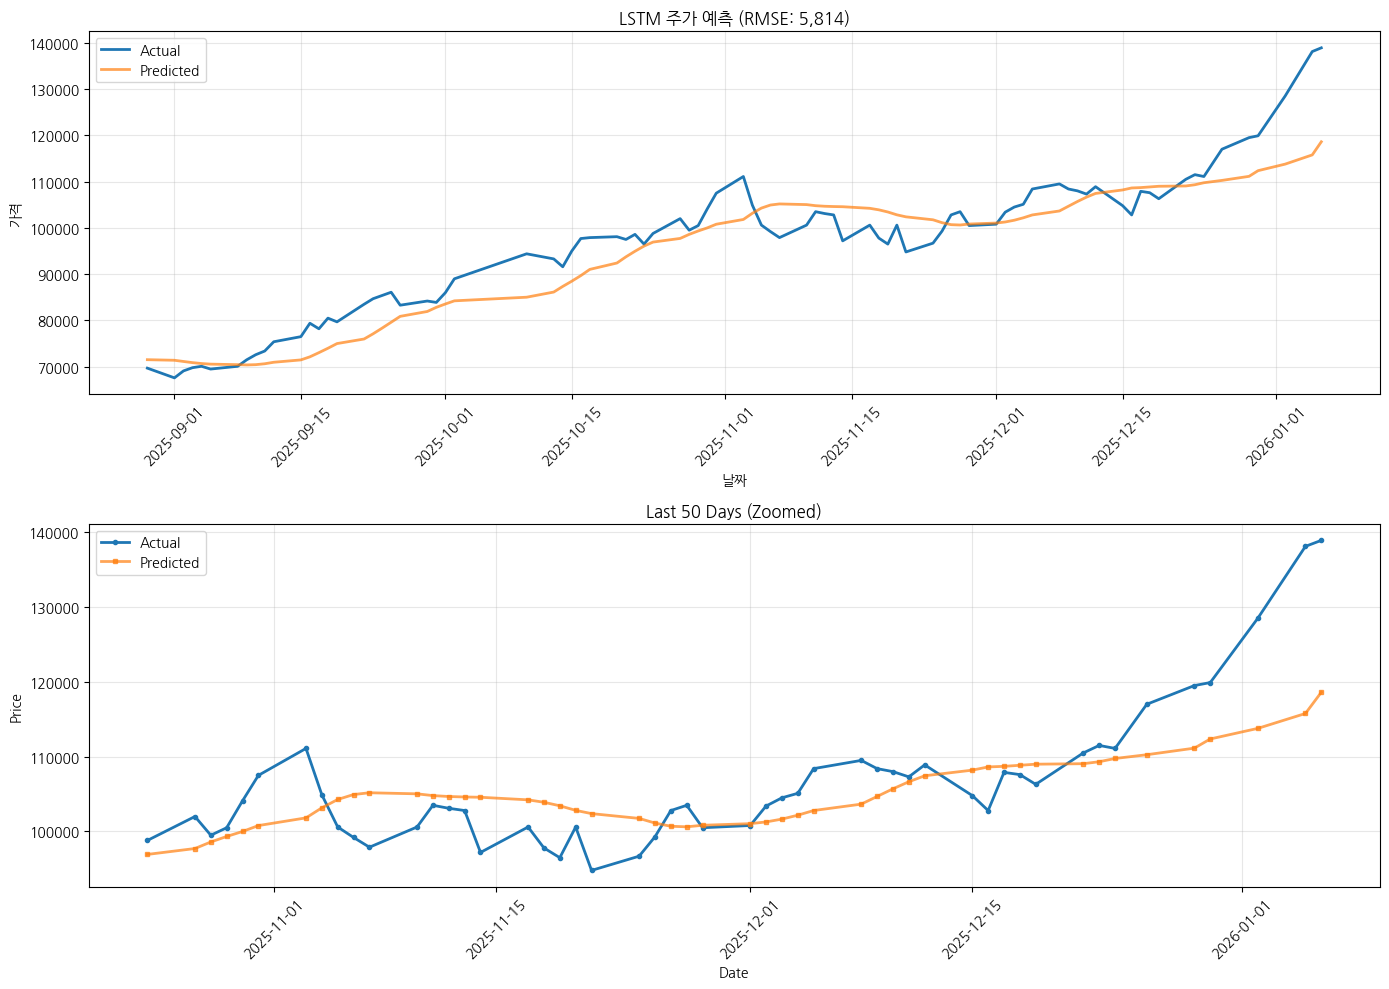

In [13]:
# 테스트 기간 날짜
test_dates = df['날짜'].iloc[train_size + SEQ_LENGTH:].values

# 예측 결과 시각화
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# 전체 비교
axes[0].plot(test_dates, y_actual, label='Actual', linewidth=2)
axes[0].plot(test_dates, y_pred, label='Predicted', linewidth=2, alpha=0.7)
axes[0].set_xlabel('날짜')
axes[0].set_ylabel('가격')
axes[0].set_title(f'LSTM 주가 예측 (RMSE: {rmse:,.0f})')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].tick_params(axis='x', rotation=45)

# 마지막 50일 확대
n_zoom = 50
axes[1].plot(test_dates[-n_zoom:], y_actual[-n_zoom:],
             label='Actual', linewidth=2, marker='o', markersize=3)
axes[1].plot(test_dates[-n_zoom:], y_pred[-n_zoom:],
             label='Predicted', linewidth=2, marker='s', markersize=3, alpha=0.7)
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Price')
axes[1].set_title(f'Last {n_zoom} Days (Zoomed)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

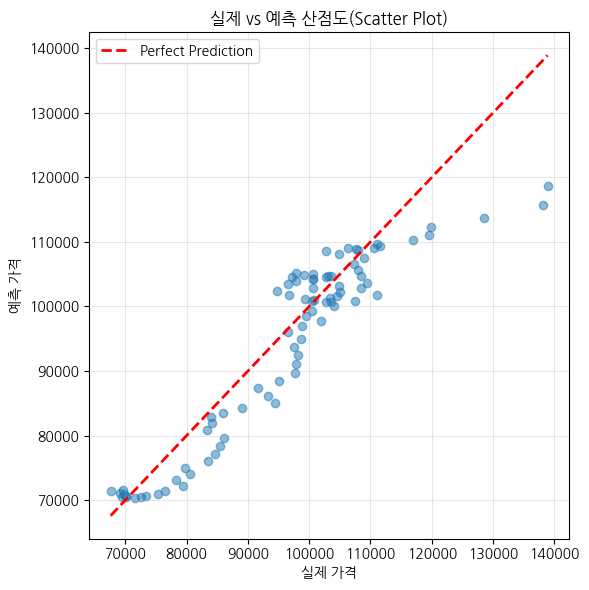

In [19]:
# 실제 vs 예측 산점도
fig, ax = plt.subplots(figsize=(6, 6))

ax.scatter(y_actual, y_pred, alpha=0.5)
ax.plot([y_actual.min(), y_actual.max()], [y_actual.min(), y_actual.max()],
        'r--', linewidth=2, label='Perfect Prediction')
ax.set_xlabel('실제 가격')
ax.set_ylabel('예측 가격')
ax.set_title('실제 vs 예측 산점도(Scatter Plot)')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

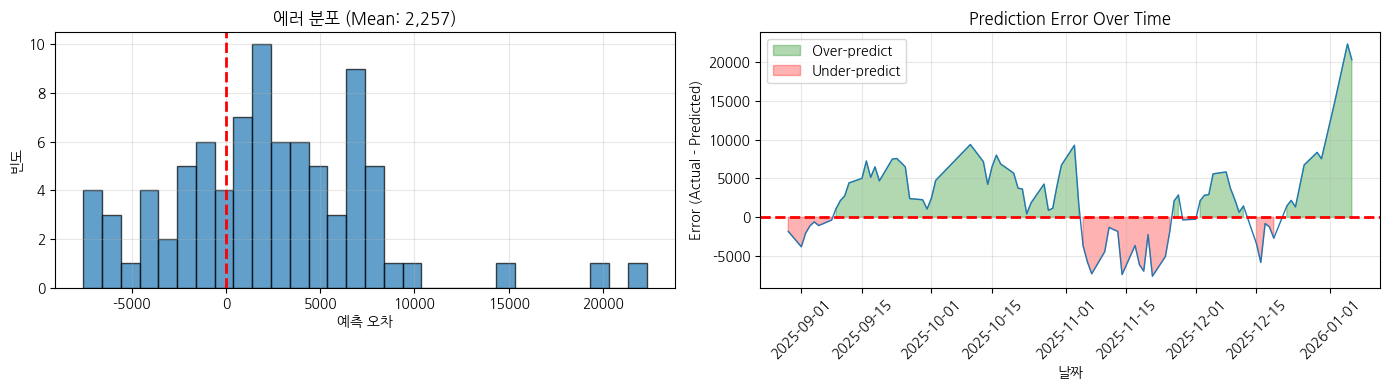

In [15]:
# 예측 오차 분포
errors = (y_actual - y_pred).flatten()

fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# 히스토그램
axes[0].hist(errors, bins=30, edgecolor='black', alpha=0.7)
axes[0].axvline(0, color='red', linestyle='--', linewidth=2)
axes[0].set_xlabel('예측 오차')
axes[0].set_ylabel('빈도')
axes[0].set_title(f'에러 분포 (Mean: {errors.mean():,.0f})')
axes[0].grid(True, alpha=0.3)

# 시계열 오차
axes[1].plot(test_dates, errors, linewidth=1)
axes[1].axhline(0, color='red', linestyle='--', linewidth=2)
axes[1].fill_between(test_dates, errors, 0, alpha=0.3,
                     where=errors >= 0, color='green', label='Over-predict')
axes[1].fill_between(test_dates, errors, 0, alpha=0.3,
                     where=errors < 0, color='red', label='Under-predict')
axes[1].set_xlabel('날짜')
axes[1].set_ylabel('Error (Actual - Predicted)')
axes[1].set_title('Prediction Error Over Time')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [16]:
# 방향 예측 정확도 (상승/하락)
actual_direction = (np.diff(y_actual.flatten()) > 0).astype(int)
pred_direction = (np.diff(y_pred.flatten()) > 0).astype(int)

direction_accuracy = (actual_direction == pred_direction).mean()

print("[방향 예측 정확도]")
print("=" * 50)
print(f"상승/하락 방향 맞춘 비율: {direction_accuracy:.1%}")
print("\n(참고: 50%는 무작위 수준)")

[방향 예측 정확도]
상승/하락 방향 맞춘 비율: 58.3%

(참고: 50%는 무작위 수준)


---
## 미래 주가 예측 (참고)

In [17]:
# 마지막 60일 데이터로 다음날 예측
last_sequence = scaled_data[-SEQ_LENGTH:].reshape(1, SEQ_LENGTH, 1)
next_day_scaled = model.predict(last_sequence)
next_day_price = scaler.inverse_transform(next_day_scaled)[0, 0]

print("[다음 거래일 예측]")
print("=" * 50)
print(f"마지막 종가: {df['종가'].iloc[-1]:,}원")
print(f"예측 종가: {next_day_price:,.0f}원")
print(f"예상 변동: {next_day_price - df['종가'].iloc[-1]:+,.0f}원")

print("\n주의: 이는 단순 예측이며 투자 조언이 아닙니다.")
print("주가 예측은 매우 어려우며 과거 데이터가 미래를 보장하지 않습니다.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
[다음 거래일 예측]
마지막 종가: 138,900원
예측 종가: 121,890원
예상 변동: -17,010원

주의: 이는 단순 예측이며 투자 조언이 아닙니다.
주가 예측은 매우 어려우며 과거 데이터가 미래를 보장하지 않습니다.


---
## 학습 정리

### 1. LSTM 주가 예측 파이프라인
```
데이터 수집 → 정규화 → 시퀀스 생성 → 모델 학습 → 예측 → 역정규화
```

### 2. 핵심 코드
```python
# 데이터 정규화
scaler = MinMaxScaler()
scaled = scaler.fit_transform(prices)

# 시퀀스 생성
X, y = create_sequences(scaled, seq_length=60)

# LSTM 모델
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(60, 1)),
    Dropout(0.2),
    LSTM(50),
    Dense(1)
])

# 학습
model.fit(X_train, y_train, epochs=100)

# 역정규화
y_pred = scaler.inverse_transform(model.predict(X_test))
```

### 3. 주의사항
- 주가 예측은 매우 어려운 문제
- 과적합 주의 (Dropout, Early Stopping)
- 다양한 특성 추가 고려 (거래량, 기술적 지표)
- 모델 성능이 좋아도 실제 투자에는 주의

---

### 다음 차시 예고
- 25차시: 자연어 처리(NLP) 기초
  - 텍스트 전처리 (토큰화)
  - TF-IDF, Word2Vec 개념
  - 금융 텍스트 분석 준비